In [1]:
import os
import sys
import h5py
import glob

import numpy as np
import mpl_scatter_density
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

mpl.style.use('seaborn-colorblind')
mpl.rc('font', size=15)
mpl.rc('figure', figsize=(8, 6))

In [2]:
sim_dir = '/scratch/08317/tg876168/ananke_subsamples/m12i-test/lsr-0/'
sim_files = sorted(glob.glob(os.path.join(sim_dir, '*.hdf5')))
sim_files

['/scratch/08317/tg876168/ananke_subsamples/m12i-test/lsr-0/lsr-0-rslice-0.m12i-res7100-subsamples.hdf5',
 '/scratch/08317/tg876168/ananke_subsamples/m12i-test/lsr-0/lsr-0-rslice-1.m12i-res7100-subsamples.hdf5',
 '/scratch/08317/tg876168/ananke_subsamples/m12i-test/lsr-0/lsr-0-rslice-2.m12i-res7100-subsamples.hdf5']

In [3]:
for i_file in range(len(sim_files)):
    with h5py.File(sim_files[i_file], 'r') as f:
        print(list(f.keys()))
        print(f['ra'].len())

['dec', 'feh', 'labels', 'parallax', 'parallax_over_error', 'pmdec', 'pmra', 'px_true', 'py_true', 'pz_true', 'ra', 'radial_velocity', 'source_id', 'vx_true', 'vy_true', 'vz_true']
50683177
['dec', 'feh', 'labels', 'parallax', 'parallax_over_error', 'pmdec', 'pmra', 'px_true', 'py_true', 'pz_true', 'ra', 'radial_velocity', 'source_id', 'vx_true', 'vy_true', 'vz_true']
13581
['dec', 'feh', 'labels', 'parallax', 'parallax_over_error', 'pmdec', 'pmra', 'px_true', 'py_true', 'pz_true', 'ra', 'radial_velocity', 'source_id', 'vx_true', 'vy_true', 'vz_true']
2


In [4]:
def subsample_data(sim_file, keys, subsample_factor=100, batch_size=100000, seed=None):

    # set random seed 
    np.random.seed(seed)

    n_batch_sample = batch_size // subsample_factor

    data = {}
    with h5py.File(sim_file, 'r') as input_f:
        n_total = input_f['ra'].len()
        slices = np.arange(n_total + batch_size, step=batch_size)

        # start slicing input data
        for i in range(len(slices) - 1):
            start = slices[i]
            stop = slices[i + 1]
            # dealing with last slice
            if stop > n_total:
                stop = n_total
                batch_size = stop - start
                n_batch_sample = batch_size // subsample_factor
            
            # randomly sample data and add properties to data dict
            rand = np.random.permutation(batch_size)[:n_batch_sample]
            for p in keys:
                if data.get(p) is None:
                    data[p] = []
                data[p].append(input_f[p][start: stop][rand])

    # convert values into numpy array
    for p in keys:
        data[p] = np.concatenate(data[p])
    
    return data

In [5]:
keys = ('feh', 'px_true', 'py_true', 'pz_true', 'vx_true', 'vy_true', 'vz_true', 'labels', )
subsample_factor = 1000

if subsample_factor > 1:
    seed = 631346
    data = subsample_data(
        sim_files[0], keys, subsample_factor=subsample_factor, seed=seed)
else:
    data = {}
    with h5py.File(sim_files[0], 'r') as input_f:
        for p in keys:
            data[p] = input_f[p][:]

In [12]:
# calculate velocity vr and vphi in Cylindrical coordinate
# vr = (x * vx + y * vy) / r
data['vr_true'] = (data['px_true']*data['vx_true'] + data['py_true']*data['vy_true'] ) / np.sqrt(
    data['px_true']**2 + data['py_true']**2)

# vphi = (x * vy - y * vx) / r
data['vphi_true'] = (data['px_true']*data['vy_true'] - data['py_true']*data['vx_true']) / np.sqrt(
    data['px_true']**2 + data['py_true']**2)

In [13]:
# get index of insitu and accreted stars
mask_insitu = (data['labels'] == 0)
N_insitu = np.sum(mask_insitu)
N_accreted = np.sum(~mask_insitu)

print('Number of in situ stars: {:d}'.format(N_insitu))
print('Number of accreted stars: {:d}'.format(N_accreted))

data_insitu = {}
data_accreted = {}
for p in data.keys():
    data_insitu[p] = data[p][mask_insitu]
    data_accreted[p] = data[p][~mask_insitu]    

Number of in situ stars: 50290
Number of accreted stars: 393


In [21]:
# To reduce scatter plot time, further subsample dataset 
subsample_plot = 1
if subsample_plot > 1:
    rand_insitu = np.random.permutation(N_insitu)[:N_insitu // subsample_plot]
    rand_accreted = np.random.permutation(N_accreted)[:N_accreted // subsample_plot]
    print('Number of in situ stars plotting sample: {:d}'.format(len(rand_insitu)))
    print('Number of accreted stars plotting sample: {:d}'.format(len(rand_accreted)))
else:
    rand_insitu = ()
    rand_accreted = ()

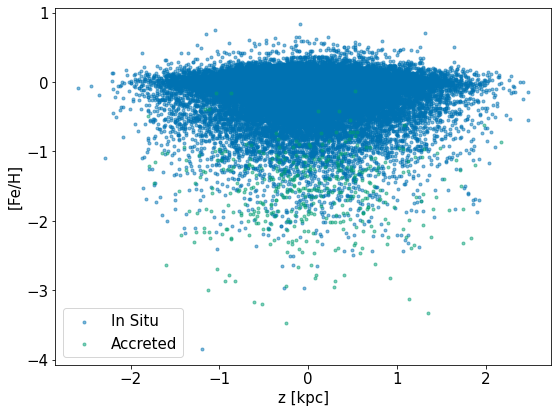

In [24]:
fig, ax = plt.subplots(1)

ax.scatter(
    data_insitu['pz_true'][rand_insitu], data_insitu['feh'][rand_insitu], 
    marker='.', alpha=0.5, label='In Situ')
ax.scatter(
    data_accreted['pz_true'][rand_accreted], data_accreted['feh'][rand_accreted],
    marker='.', alpha=0.5, label='Accreted')

ax.set_xlabel('z [kpc]')
ax.set_ylabel('[Fe/H]')
ax.legend(loc=0)

fig.tight_layout()
# fig.savefig('plots/ztrue_feh.png', dpi=300, bbox_inches='tight')

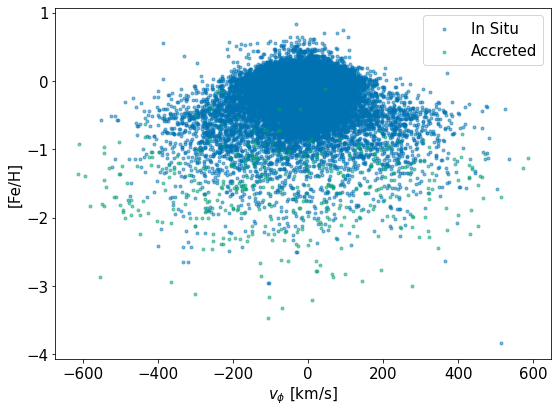

In [25]:
fig, ax = plt.subplots(1)

ax.scatter(
    data_insitu['vphi_true'][rand_insitu], data_insitu['feh'][rand_insitu], 
    marker='.', alpha=0.5, label='In Situ')
ax.scatter(
    data_accreted['vphi_true'][rand_accreted], data_accreted['feh'][rand_accreted],
    marker='.', alpha=0.5, label='Accreted')

ax.set_xlabel(r'$v_\phi$ [km/s]')
ax.set_ylabel('[Fe/H]')
ax.legend(loc=0)

fig.tight_layout()
# fig.savefig('plots/vphi_feh.png', dpi=300, bbox_inches='tight')

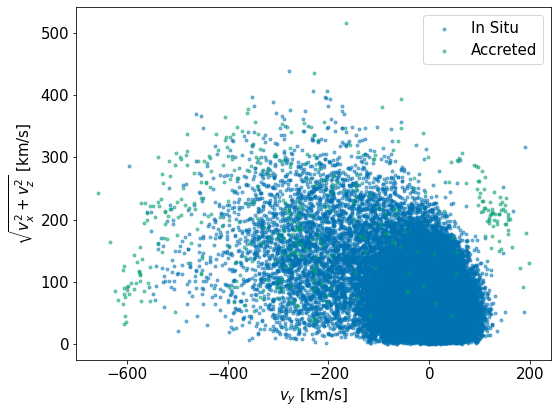

In [30]:
fig, ax = plt.subplots(1)

y = np.sqrt(data_insitu['vx_true'][rand_insitu]**2 + 
            data_insitu['vz_true'][rand_insitu]**2)
ax.scatter(
    data_insitu['vy_true'][rand_insitu], y,
    marker='.', alpha=0.5, label='In Situ')

y = np.sqrt(data_accreted['vx_true'][rand_accreted]**2 + 
            data_accreted['vz_true'][rand_accreted]**2)
ax.scatter(
    data_accreted['vy_true'][rand_accreted], y,
    marker='.', alpha=0.5, label='Accreted')

ax.set_xlabel(r'$v_y$ [km/s]')
ax.set_ylabel(r'$\sqrt{v_x^2 + v_z^2}$ [km/s]')
ax.legend(loc=0)

fig.tight_layout()
# fig.savefig('plots/toomre.png', dpi=300, bbox_inches='tight')

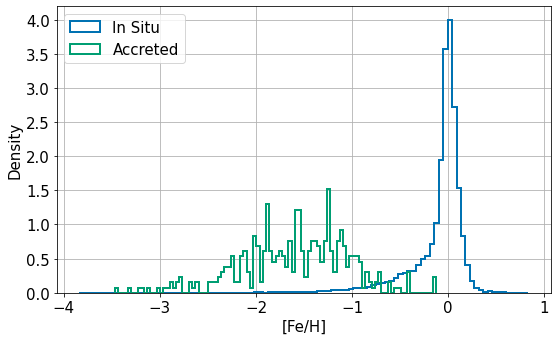

In [31]:
# plot [Fe / H] histogram for insitu and accreted stars
# histogram plotting is fast, so we do not need to subsample the data
fig, ax = plt.subplots(1, figsize=(8, 5))

# bins = np.arange(-4., 1.5, 0.125)
bins = 100
ax.hist(data_insitu['feh'], bins, density=True, 
        histtype='step', lw=2, label='In Situ')
ax.hist(data_accreted['feh'], bins, density=True, 
        histtype='step', lw=2, label='Accreted')

# format axes and figurea
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Density')
ax.grid(True)
ax.legend(loc=2)

fig.tight_layout()
# fig.savefig('plots/metalicity.png', dpi=300, bbox_inches='tight')